# Dimensionality reduction and clustering of movement types
Mar2024 \
author: Inês Laranjeira

In [1]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import re
from mpl_toolkits.mplot3d import Axes3D

from brainbox.task.trials import find_trial_ids
from brainbox.behavior.training import get_sessions, get_training_status
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from one.api import ONE
from collections import defaultdict

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, KFold, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.manifold import TSNE
from scipy.interpolate import interp1d

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label
from one_functions_generic import prepro
from design_functions import wheel_velocity
from data_processing import time_intervals, process_quiescence
from wheel_functions import find_periods_below_threshold, create_movement_array, stack_trial_events, wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        # design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        # unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]

        design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < session_end]
        
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 14.1kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 15.6kB/s]


_
poch_DY_013.png_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 20.2kB/s]


portances.svg_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 16.2kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 14.1kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 17.0kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


## Concatenate sessions of the same animal

In [5]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Loop through animals

In [6]:

# all_animals_df = pd.DataFrame(columns=np.concatenate(([var], var_names)))

for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]

        " Prepare design matrix "
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix
        bins = unnorm_mat['Bin']
        design_matrix_heading['Bin'] = bins
        
        # Absolute wheel velocity
        design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])
        unnorm_mat['avg_wheel_vel'] = np.abs(unnorm_mat['avg_wheel_vel'])

        # Wheel data
        bin_size = 0.05
        wheel = wheel_trial_epoch(one, session_trials, session, bin_size)
        reduced_wheel = wheel.drop_duplicates(subset=['trial', 'wheel', 'movement', 'trial_epoch', 'feedback', 
                                       'next_feedback', 'signed_contrast', 'response', 
                                       'reaction'], keep='first') # get wheel to have same resolution as bin_size; 
        last_timestep = wheel.drop_duplicates(subset=['trial', 'wheel', 'movement', 'trial_epoch', 'feedback', 
                                            'next_feedback', 'signed_contrast', 'response', 
                                            'reaction'], keep='last')['time']
        reduced_wheel['time'] = (np.array(reduced_wheel['time']) + np.array(last_timestep)) / 2
        
        wheel_timings = process_quiescence(reduced_wheel)

        # # Save results
        # if m == 0:
        #     all_animals_df = final_df.copy()
        # else:
        #     all_animals_df = all_animals_df.append(final_df)
        

Fitting mouse SWC_052


/tmp/ipykernel_32150/4165372865.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_wheel['time'] = (np.array(reduced_wheel['time']) + np.array(last_timestep)) / 2
/home/ines/repositories/representation_learning_variability/Functions/data_processing.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])


In [7]:
def interpolate(time_snippet, movement_snippet, size, plot):
    x = np.arange(0, len(time_snippet))
    y = movement_snippet
    f = interp1d(x, y, 'cubic')
    
    # New grid coordinates
    new_x = np.linspace(0, len(x)-1, size)  # Upscale to 6 columns

    # Interpolate values at new grid coordinates
    rescaled_array = f(new_x)
    
    if plot == True:
        plt.plot(x, y, 'o', new_x, rescaled_array, '-')
        plt.plot(x, movement_snippet)
        plt.xlabel('Time')
        plt.ylabel('Wheel velocity')
        plt.show()
            
    return rescaled_array

## Stack movements and interpolate to have the same size

In [8]:
movement_onsets = wheel_timings['movement_onset'].unique()
# snippet_lengths = []
stacked_movements = np.array([])
movement_info = pd.DataFrame(columns=['trial_epoch', 'feedback', 'next_feedback', 'signed_contrast'])

for m, onset in enumerate(movement_onsets[:-1]):
        
    movement_true = wheel_timings.loc[wheel_timings['movement_onset']==onset, 'movement']
    offset = movement_onsets[m+1]
    
    if list(movement_true)[0] == 1.0: 
        
        snippet = reduced_wheel.loc[(reduced_wheel['time']>=onset) & (reduced_wheel['time']<offset)]
        movement_snippet = snippet['wheel']
        time_snippet = snippet['time']
        
        # snippet_lengths = np.concatenate((snippet_lengths, [len(movement_snippet)]))
        if len(time_snippet) > 3:

            # Interpolate values at new grid coordinates
            rescaled_array = interpolate(time_snippet, movement_snippet, size=100, plot=False)
            
            # Save meta data
            movement = pd.DataFrame(columns=['trial_epoch', 'feedback', 'next_feedback', 'signed_contrast'], index=[0])
            movement['trial_epoch'][0] = list(snippet['trial_epoch'])[0]
            movement['feedback'][0] = list(snippet['feedback'])[0]
            movement['next_feedback'][0] = list(snippet['next_feedback'])[0]
            movement['signed_contrast'][0] = list(snippet['signed_contrast'])[0]
             
            if len(stacked_movements) == 0:
                stacked_movements = rescaled_array
                movement_info = movement
            else:
                stacked_movements = np.vstack((stacked_movements, rescaled_array))
                movement_info = movement_info.append(movement)


/tmp/ipykernel_32150/3081288836.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movement_info = movement_info.append(movement)
/tmp/ipykernel_32150/3081288836.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movement_info = movement_info.append(movement)
/tmp/ipykernel_32150/3081288836.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movement_info = movement_info.append(movement)
/tmp/ipykernel_32150/3081288836.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movement_info = movement_info.append(movement)
/tmp/ipykernel_32150/3081288836.py:35: FutureWarning: The frame.append method is deprecated and will be removed from

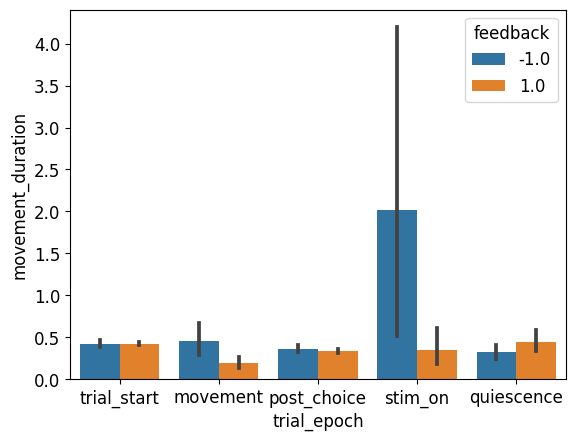

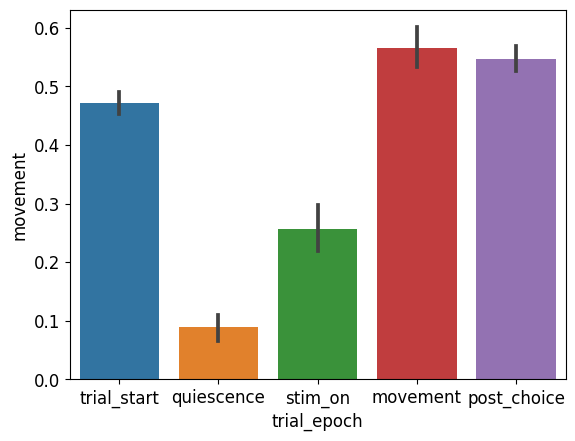

In [34]:
vars_to_plot = ['movement_duration']
var_names = ['Movement duration']
# fig, axs = plt.subplots(nrows=1, ncols=len(vars_to_plot), sharex=True, sharey=False, figsize=[12, 6])
plt.rc('font', size=12)

movements = wheel_timings.loc[wheel_timings['movement']==1.0]
stills = wheel_timings.loc[wheel_timings['movement']==0]

counts = wheel_timings.groupby(['trial_epoch', 'trial'])['movement'].count()  # 
counts = counts.reset_index(level = [0, 1]) 

movement_count = movements.groupby(['trial_epoch', 'trial'])['movement'].count()  # 
movement_count = movement_count.reset_index(level = [0, 1]) 
movement_count['movement'] = movement_count['movement'] / counts['movement']

stillness_count = stills.groupby(['trial_epoch', 'trial'])['movement'].count()  # 
stillness_count = stillness_count.reset_index(level = [0, 1]) 
stillness_count['movement'] = stillness_count['movement'] / counts['movement']

sns.barplot(y=vars_to_plot[0], x='trial_epoch', hue='feedback', data=movements)
plt.show()
# sns.barplot(y='movement', x='trial_epoch', data=movement_count)
# plt.show()
# sns.barplot(y='movement', x='trial_epoch', data=stillness_count)
# plt.show()
sns.barplot(y='movement', x='trial_epoch', data=wheel_timings)
plt.show()
# for v, var in enumerate(vars_to_plot):
    
#     sns.barplot(y=var, x='trial_epoch', data=wheel_timings, ax=axs[0, v])
#     axs[0, v].set_ylabel(var_names[v])
#     # axs[1, v].set_ylabel(var_names[v])
#     axs[0, v].set_xlabel(var_names[v])
#     # axs[1, v].set_xlabel('Next feedback')
# plt.tight_layout()
# plt.show()


## Build design matrix

In [10]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = stacked_movements # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)
scaled = scaler.transform(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaled)

Reconstruction error: 0.6392808745650936


(0.0, 100.0)

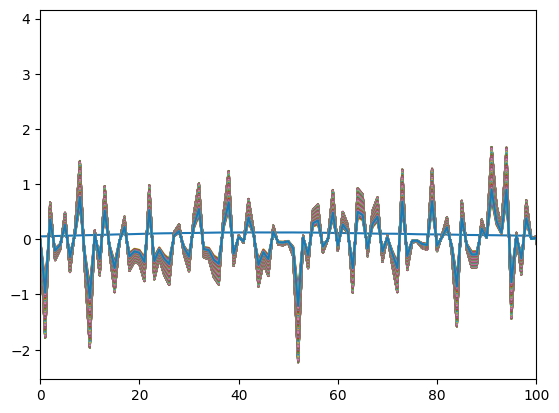

In [27]:

# # Example data
# data = np.random.randn(100, 10)  # 100 samples, 10 features

# # Perform PCA
# pca = PCA(n_components=10)  # Keep all components for demonstration
# pca.fit(data)

# # Transform data into PC space
# data_transformed = pca.transform(data)


# Select only the first k principal components for reconstruction
k = 1
selected_components = X_reduced[:, :k]

# Reconstruct the data using the selected components
reconstructed_data = np.dot(selected_components, pca.components_[:k, :])  # Multiply by loadings
reconstructed_data += pca.mean_  # Add back the mean

# Check reconstruction error (optional)
reconstruction_error = np.mean(np.square(scaled - reconstructed_data))

print("Reconstruction error:", reconstruction_error)
plt.plot(pca.components_[:k, :][0])
plt.plot(reconstructed_data)
plt.xlim([0, 100])

In [22]:
pca.components_[:4, :][0]

array([0.05291212, 0.05484116, 0.05738499, 0.05947283, 0.0617468 ,
       0.06397595, 0.06632863, 0.06858844, 0.07128516, 0.07363645,
       0.07582926, 0.078293  , 0.0801564 , 0.08205305, 0.08425619,
       0.08744503, 0.0897387 , 0.09143616, 0.09242502, 0.09505879,
       0.09760322, 0.10000728, 0.10243488, 0.10491845, 0.10701162,
       0.10880619, 0.10972634, 0.11111222, 0.11262396, 0.11382261,
       0.11430431, 0.11503927, 0.11652585, 0.11810115, 0.11947236,
       0.1209015 , 0.12234114, 0.12333965, 0.12308257, 0.12308503,
       0.12379667, 0.1240905 , 0.12453602, 0.12450076, 0.12449362,
       0.12420698, 0.12416916, 0.12421797, 0.12387746, 0.12395405,
       0.12410031, 0.12424504, 0.12339731, 0.12326021, 0.1228306 ,
       0.1217604 , 0.12029058, 0.11845527, 0.11712826, 0.11578018,
       0.1148863 , 0.11443756, 0.11282104, 0.11157015, 0.11028442,
       0.10850143, 0.10633845, 0.10467442, 0.1032047 , 0.10228196,
       0.10111056, 0.10125442, 0.10010131, 0.09865504, 0.09696

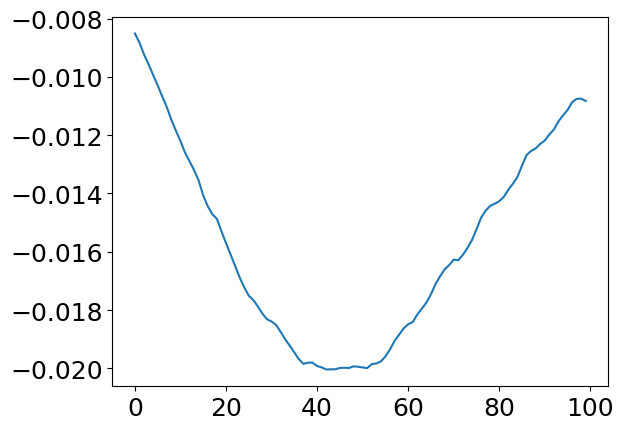

In [320]:
x = np.arange(0, 100, 1)   
y = np.mean(reconstructed_data, axis=0)

plt.plot(reconstructed_data[0, :])
# yerr = np.std(y, axis=0)/np.sqrt(len(x))

# plt.plot(x)
# plt.errorbar(x, y, yerr)
# ax.errorbar(x, y,
#         xerr=xerr,
#         yerr=yerr,
#         fmt='-o',
#         color=flatui[q],
#         alpha=0.7)


In [304]:
np.shape(reconstructed_data)

(2083, 100)

Text(0, 0.5, '% Variance explained')

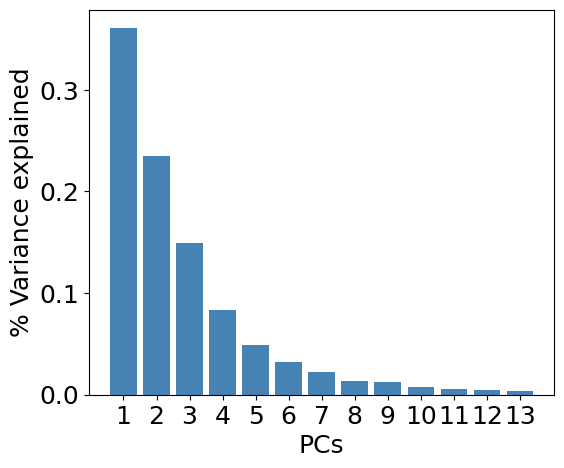

In [264]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = 13
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc+1, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [276]:
# Plot projections of datapoints into first 3 principal components
ref_df = pd.DataFrame()
ref_df['pc1'] = X_reduced[:, 0].transpose()
ref_df['pc2'] = X_reduced[:, 1].transpose()
ref_df['pc3'] = X_reduced[:, 2].transpose()
ref_df['pc4'] = X_reduced[:, 3].transpose()
ref_df['trial_epoch'] = list(movement_info['trial_epoch'])
ref_df['feedback'] = list(movement_info['feedback'])
ref_df['next_feedback'] = list(movement_info['next_feedback'])
ref_df['signed_contrast'] = list(movement_info['signed_contrast'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
           cmap=plt.cm.Set1, edgecolor='k', s=40) # cmap=plt.cm.Set1
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()


/tmp/ipykernel_11025/1506113813.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
/tmp/ipykernel_11025/1506113813.py:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
/tmp/ipykernel_11025/1506113813.py:20: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
/tmp/ipykernel_11025/1506113813.py:22: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])


<Figure size 800x600 with 0 Axes>

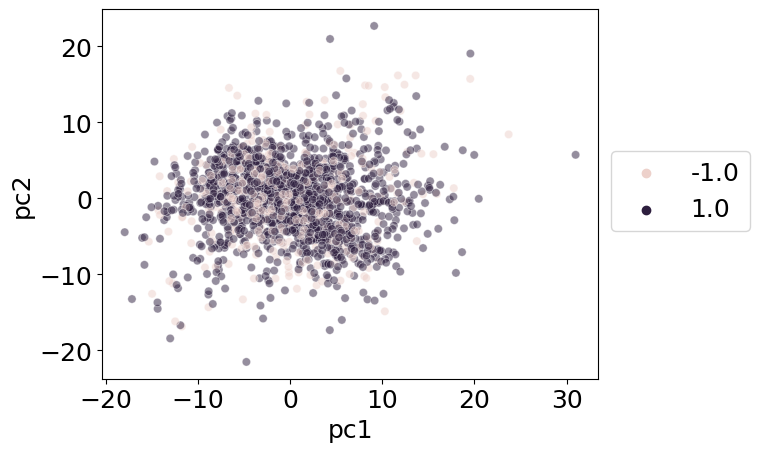

In [277]:
sns.scatterplot(x='pc1', y='pc2', data=ref_df, hue='feedback', alpha=0.5) #  hue='feedback', 
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))

In [288]:
"""
Average across sessions
"""
ref_df['pc1'] = X_reduced[:, 0].transpose()
ref_df['pc2'] = X_reduced[:, 1].transpose()
ref_df['pc3'] = X_reduced[:, 2].transpose()
ref_df['pc4'] = X_reduced[:, 3].transpose()

# , 'feedback', 'next_feedback', 'signed_contrast'
avg_trans = ref_df.groupby(['trial_epoch', 'feedback']).agg(
     avg_1=pd.NamedAgg(column="pc1", aggfunc=np.mean),
     avg_2=pd.NamedAgg(column="pc2", aggfunc=np.mean),
     avg_3=pd.NamedAgg(column="pc3", aggfunc=np.mean),
     avg_4=pd.NamedAgg(column="pc4", aggfunc=np.mean),
     std_1=pd.NamedAgg(column="pc1", aggfunc=np.std),
     std_2=pd.NamedAgg(column="pc2", aggfunc=np.std),
     std_3=pd.NamedAgg(column="pc3", aggfunc=np.std),
     std_4=pd.NamedAgg(column="pc4", aggfunc=np.std),
     )
avg_trans = avg_trans.reset_index(level=[0, 1])

In [289]:
avg_trans

,trial_epoch,feedback,avg_1,avg_2,avg_3,avg_4,std_1,std_2,std_3,std_4
0,movement,-1.0,-1.592567,1.906950,-1.076261,-0.481663,7.717739,7.625603,3.701422,2.436385
1,movement,1.0,-4.754645,0.660035,-1.907015,0.361880,6.956376,6.842467,4.634384,3.153029
2,post_choice,-1.0,0.241592,0.021243,0.285862,0.431492,6.214679,4.976825,3.955430,2.770107
3,post_choice,1.0,2.136807,0.223669,-0.403511,0.086565,6.539669,4.412043,3.696595,2.829681
4,quiescence,-1.0,7.248377,10.248327,3.421151,-2.429584,0.952067,0.853642,0.060941,0.099034
5,quiescence,1.0,-2.413414,1.610837,-2.074689,0.028313,NaN,NaN,NaN,NaN
6,stim_on,-1.0,-3.842479,3.244055,-0.791369,-0.612440,NaN,NaN,NaN,NaN
7,stim_on,1.0,-2.647041,-1.307352,-1.858281,0.432668,2.451588,0.595013,0.003238,0.014049
8,trial_start,-1.0,-0.138729,-0.450146,0.914304,-0.423328,4.953571,4.487887,3.988433,2.872842
9,trial_start,1.0,-0.376212,-0.287102,0.329343,-0.071477,4.928898,4.443064,3.650829,2.936284


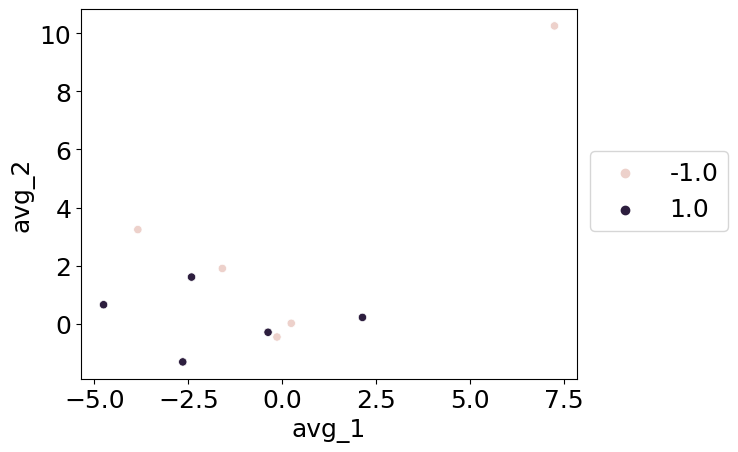

In [297]:
sns.scatterplot(x='avg_1', y='avg_2', hue='feedback', data=avg_trans)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))

In [292]:
    
x = avg_trans['avg_1']
y = avg_trans['avg_2']
xerr = avg_trans['std_1']/np.sqrt(np.sum(mice['quantile']==qua))
yerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_2']/np.sqrt(np.sum(mice['quantile']==qua))


ax.errorbar(x, y,
        xerr=xerr,
        yerr=yerr,
        fmt='-o',
        color=flatui[q],
        alpha=0.7)



"""
Get mice and corresponding quartiles
"""
mice = metrics_sorted.dropna().groupby(['subject_uuid']).agg(
     quantile=pd.NamedAgg(column="quantile", aggfunc=np.mean),
     )
mice = mice.reset_index(level=[0])


quartiles = [1., 2., 3., 4.]
#quartiles = [1., 2., 3.]

flatui = ["#9b59b6", "#34495e", "#95a5a6", "#3498db"] # , "#95a5a6",  "#34495e"
quartile_start = ['First bin - Quartile 1', 'First bin - Quartile 2', 'First bin - Quartile 3', 'First bin - Quartile 4']

fig, ax = plt.subplots(figsize=[10,8])

for q, qua in enumerate(quartiles):
    
    x = avg_trans.loc[avg_trans['quantile']==qua, 'avg_1']
    y = avg_trans.loc[avg_trans['quantile']==qua, 'avg_2']
    xerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_1']/np.sqrt(np.sum(mice['quantile']==qua))
    yerr = avg_trans.loc[avg_trans['quantile']==qua, 'std_2']/np.sqrt(np.sum(mice['quantile']==qua))


    ax.errorbar(x, y,
            xerr=xerr,
            yerr=yerr,
            fmt='-o',
            color=flatui[q],
            alpha=0.7)
    

    if q==1:
        
        ax.scatter(list(x)[0], list(y)[0], marker='^', s=500, color=flatui[q], label='First bin')
        ax.scatter(list(x)[-1], list(y)[-1], marker='v', s=500, color=flatui[q], label='Last bin')
    else:
        ax.scatter(list(x)[0], list(y)[0], marker='^', s=500, color=flatui[q])
        ax.scatter(list(x)[-1], list(y)[-1], marker='v', s=500, color=flatui[q])


ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.legend()
plt.show()

NameError: name 'mice' is not defined